In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"urjamandalisvnit","key":"1a4d6e7fb2484b89d3e4ef0aefee0eb2"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download bhaveshmittal/melanoma-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset
License(s): CC0-1.0
  0% 0.00/79.4M [00:00<?, ?B/s]
100% 79.4M/79.4M [00:00<00:00, 1.14GB/s]


In [4]:
!unzip melanoma-cancer-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Malignant/1530.jpg  
  inflating: train/Malignant/1531.jpg  
  inflating: train/Malignant/1532.jpg  
  inflating: train/Malignant/1533.jpg  
  inflating: train/Malignant/1534.jpg  
  inflating: train/Malignant/1535.jpg  
  inflating: train/Malignant/1536.jpg  
  inflating: train/Malignant/1537.jpg  
  inflating: train/Malignant/1538.jpg  
  inflating: train/Malignant/1539.jpg  
  inflating: train/Malignant/154.jpg  
  inflating: train/Malignant/1540.jpg  
  inflating: train/Malignant/1541.jpg  
  inflating: train/Malignant/1542.jpg  
  inflating: train/Malignant/1543.jpg  
  inflating: train/Malignant/1544.jpg  
  inflating: train/Malignant/1545.jpg  
  inflating: train/Malignant/1546.jpg  
  inflating: train/Malignant/1547.jpg  
  inflating: train/Malignant/1548.jpg  
  inflating: train/Malignant/1549.jpg  
  inflating: train/Malignant/155.jpg  
  inflating: train/Malignant/1550.jpg  
  inflating: train/Malignant/15

In [5]:
# Importing necessary libraries

import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device : {device}')

Using device : cuda


In [7]:
imgSize = 112

# Training transformer
transformer = transforms.Compose([
    transforms.RandomRotation(degrees = 20),

    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),

    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),

    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Validation transformer
valTransformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),

    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [8]:
path = '/content/test'
valPath = '/content/test'

trainData = datasets.ImageFolder(root = path, transform = transformer)
valData = datasets.ImageFolder(root = valPath, transform = valTransformer)

In [9]:
batchSize = 32

trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True, num_workers = 4)
valLoader = DataLoader(valData, batch_size = batchSize, shuffle = False, num_workers = 4)

In [10]:
# Using a pre-trained EfficientNetV2L model
model = models.efficientnet_v2_l(weights = 'DEFAULT')

# Modifying final classifier layer
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth


100%|██████████| 455M/455M [00:02<00:00, 183MB/s]


In [11]:
model = nn.DataParallel(model).to(device)
# Defining the loss, optimizer, and annealer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = ReduceLROnPlateau(optimizer, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5)

In [12]:
patience = 5
minDelta = 0.01
currentPatience = 0
bestLoss = float('inf')

In [13]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

# Lists to store metrics
trainLosses = []
valLosses = []
trainAccs = []
valAccs = []

epochs = 30

for epoch in range(epochs):

    # =========================
    # Training Phase
    # =========================
    model.train()
    runningLoss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        runningLoss += loss.item()

        # ---- Train Accuracy ----
        preds = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    trainLoss = runningLoss / len(trainLoader)
    trainAcc = correct / total * 100

    trainLosses.append(trainLoss)
    trainAccs.append(trainAcc)

    # =========================
    # Validation Phase
    # =========================
    model.eval()
    valLoss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valLoss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    avgValLoss = valLoss / len(valLoader)
    valAcc = correct / total * 100

    valLosses.append(avgValLoss)
    valAccs.append(valAcc)

    # =========================
    # Print after each epoch
    # =========================
    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Loss: {trainLoss:.4f} | Train Acc: {trainAcc:.2f}% || "
        f"Val Loss: {avgValLoss:.4f} | Val Acc: {valAcc:.2f}%"
    )

    # =========================
    # Early Stopping
    # =========================
    if avgValLoss < bestLoss - minDelta:
        bestLoss = avgValLoss
        currentPatience = 0
    else:
        currentPatience += 1
        if currentPatience >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step(avgValLoss)

Epoch [1/30] | Train Loss: 0.3610 | Train Acc: 85.15% || Val Loss: 0.6047 | Val Acc: 77.95%
Epoch [2/30] | Train Loss: 0.2586 | Train Acc: 90.30% || Val Loss: 0.2155 | Val Acc: 92.60%
Epoch [3/30] | Train Loss: 0.2409 | Train Acc: 91.55% || Val Loss: 2.3772 | Val Acc: 93.00%
Epoch [4/30] | Train Loss: 0.2245 | Train Acc: 91.40% || Val Loss: 0.1603 | Val Acc: 93.55%
Epoch [5/30] | Train Loss: 0.1854 | Train Acc: 93.55% || Val Loss: 0.1725 | Val Acc: 96.10%
Epoch [6/30] | Train Loss: 0.1689 | Train Acc: 93.85% || Val Loss: 0.1191 | Val Acc: 95.80%
Epoch [7/30] | Train Loss: 0.1757 | Train Acc: 94.15% || Val Loss: 0.0982 | Val Acc: 96.85%
Epoch [8/30] | Train Loss: 0.1637 | Train Acc: 94.30% || Val Loss: 0.1713 | Val Acc: 93.40%
Epoch [9/30] | Train Loss: 0.1632 | Train Acc: 94.30% || Val Loss: 0.0848 | Val Acc: 97.40%
Epoch [10/30] | Train Loss: 0.1424 | Train Acc: 95.05% || Val Loss: 0.1378 | Val Acc: 94.45%
Epoch [11/30] | Train Loss: 0.1336 | Train Acc: 95.15% || Val Loss: 0.0901 | Va

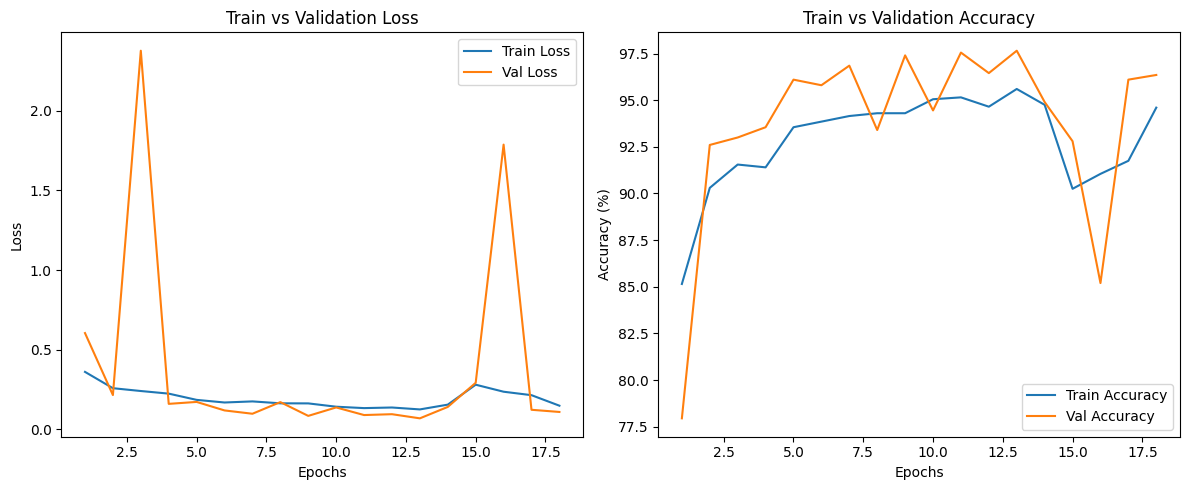

In [14]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(trainLosses) + 1)

# Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, trainLosses, label="Train Loss")
plt.plot(epochs_range, valLosses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, trainAccs, label="Train Accuracy")
plt.plot(epochs_range, valAccs, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []
all_probs = [] # Initialize all_probs list

model.eval()
valLoss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        valLoss += loss.item()

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # ---- Store for confusion matrix ----
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy()) # Store probabilities

avgValLoss = valLoss / len(valLoader)
valAcc = correct / total * 100

In [17]:
# Convert to numpy arrays & flatten
y_true = np.array(all_labels).astype(int).ravel()
y_pred = np.array(all_preds).astype(int).ravel()

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[971  29]
 [ 44 956]]


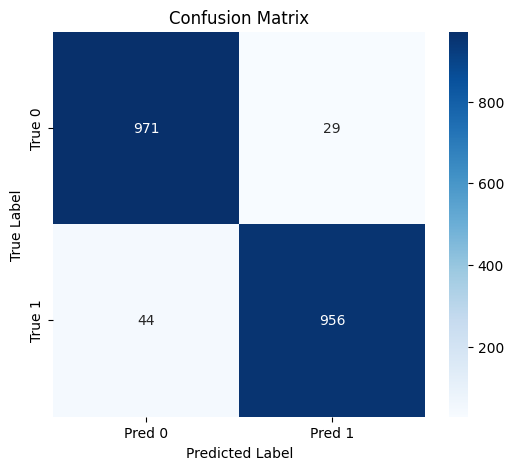

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))


              precision    recall  f1-score   support

     Class 0       0.96      0.97      0.96      1000
     Class 1       0.97      0.96      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Precision: 0.9706
Recall: 0.9560
F1-score: 0.9632


In [21]:
from sklearn.metrics import roc_curve, auc

y_probs = np.array(all_probs).ravel()   # sigmoid outputs

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)


AUC: 0.992486


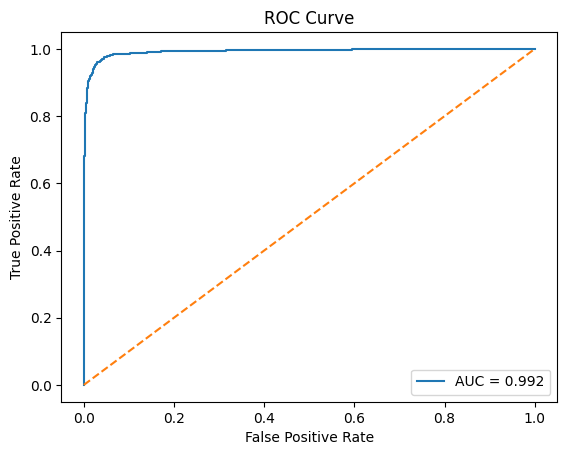

In [22]:
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [23]:
import pickle

with open("model_weights.pkl", "wb") as f:
    pickle.dump(model.state_dict(), f)

In [24]:
torch.save({
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "val_loss": avgValLoss
}, "best_model.pth")
